## Modélisation prédictive 

In [179]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,  RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [180]:
merged_data = pd.read_excel("covid_and_coordinates.xlsx")

In [181]:
# Define the target column
target_column = 'Cases - cumulative total per 100000 population'


## Régression 

#### Régression linéaire (OLS)

In [182]:
import statsmodels.api as sm

def ols_regression(data, target):
    X = data.drop(columns=[target])
    y = data[target]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    print(model.summary())
    
    return model

def evaluate_model(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_pred = model.predict(sm.add_constant(X_test))
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return r2_scores, mse_scores

def normalize_data(data):
    scaler = RobustScaler()
    data_normalized = scaler.fit_transform(data)
    return pd.DataFrame(data_normalized, columns=data.columns)

def plot_best_fit_line(model, X, y, title):
    slope = model.params['Latitude']
    intercept = model.params['const']
    
    plt.scatter(X, y, color='blue', label='Actual data')
    
    x_values = np.linspace(X.min(), X.max(), 100)
    y_values = intercept + slope * x_values
    plt.plot(x_values, y_values, color='red', label='Best fit line')
    
    plt.xlabel('Latitude')
    plt.ylabel(target_column)
    plt.title(title)
    plt.legend()
    
    plt.show()



In [183]:
merged_data_normalized = merged_data[["Latitude", target_column]].copy()
merged_data_normalized['Latitude'] = abs(merged_data['Latitude'])
merged_data_normalized['Cases - cumulative total per 100000 population'] = np.log(merged_data_normalized[target_column])


ols_model = ols_regression(merged_data_normalized, target_column)

X = merged_data_normalized[['Latitude']]
y = merged_data_normalized[target_column]
r2_scores_osl, mse_scores_osl = evaluate_model(ols_model, X, y)

print("Mean R2:", np.mean(r2_scores_osl))
print("Mean MSE:", np.mean(mse_scores_osl))


                                          OLS Regression Results                                          
Dep. Variable:     Cases - cumulative total per 100000 population   R-squared:                       0.221
Model:                                                        OLS   Adj. R-squared:                  0.218
Method:                                             Least Squares   F-statistic:                     61.93
Date:                                            Fri, 12 Apr 2024   Prob (F-statistic):           1.65e-13
Time:                                                    16:27:23   Log-Likelihood:                -426.78
No. Observations:                                             220   AIC:                             857.6
Df Residuals:                                                 218   BIC:                             864.3
Df Model:                                                       1                                         
Covariance Type:                     

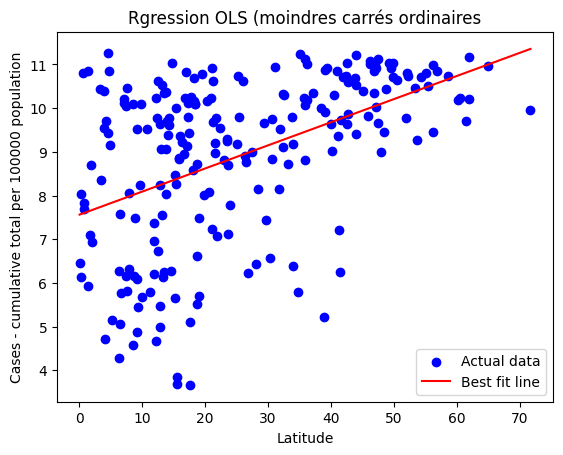

In [184]:
plot_best_fit_line(ols_model, X['Latitude'], y, "Rgression OLS (moindres carrés ordinaires")

#### Theil Sen Regression (Robust Regression like MM-estimator)

In [185]:
from sklearn.linear_model import TheilSenRegressor

def theil_sen_regression(X, y):
    model = TheilSenRegressor()
    model.fit(X, y)
    return model

merged_data_normalized = merged_data[["Latitude", target_column]].copy()
merged_data_normalized['Latitude'] = abs(merged_data_normalized['Latitude'])
merged_data_normalized[target_column] = np.log(merged_data_normalized[target_column])

X = merged_data_normalized[['Latitude']]
y = merged_data_normalized[target_column]
theil_sen_model = theil_sen_regression(X, y)



In [186]:
def evaluate_model_TS(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return r2_scores, mse_scores

r2_scores_ts, mse_scores_ts = evaluate_model_TS(theil_sen_model, X, y)

print("Mean R2:", np.mean(r2_scores_ts))
print("Mean MSE:", np.mean(mse_scores_ts))


Mean R2: 0.18882098916979775
Mean MSE: 2.917764173122897


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but TheilSenRegressor was fitted with feature names
  warnings.warn(


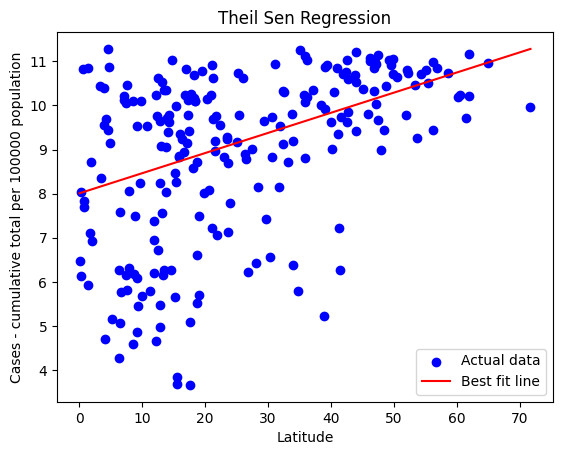

In [187]:
def plot_best_fit_line_TS(model, X, y):
    plt.scatter(X, y, color='blue', label='Actual data')
    
    x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_values = model.predict(x_values)
    plt.plot(x_values, y_values, color='red', label='Best fit line')
    
    plt.xlabel('Latitude')
    plt.ylabel(target_column)
    plt.title('Theil Sen Regression')
    plt.legend()
    
    plt.show()
plot_best_fit_line_TS(theil_sen_model, X, y)

#### Polynomial Regression 

In [188]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression


def polynomial_regression(X, y, degree=2):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    return model, poly_features

def evaluate_model(model, X, y, poly_features, n_splits=5, n_repeats=10):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_test_poly = poly_features.transform(X_test)
        
        y_pred = model.predict(X_test_poly)
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return r2_scores, mse_scores

merged_data_normalized = merged_data[["Latitude", target_column]].copy()
merged_data_normalized['Latitude'] = abs(merged_data_normalized['Latitude'])
merged_data_normalized[target_column] = np.log(merged_data_normalized[target_column])
scaler = StandardScaler()
merged_data_normalized = pd.DataFrame(scaler.fit_transform(merged_data_normalized), columns=merged_data_normalized.columns)

X = merged_data_normalized[['Latitude']]
y = merged_data_normalized[target_column]
degree = 10 
polynomial_model, poly_features = polynomial_regression(X, y, degree)

r2_scores_poly, mse_scores_poly = evaluate_model(polynomial_model, X, y, poly_features)

print("Mean R2:", np.mean(r2_scores_poly))
print("Mean MSE:", np.mean(mse_scores_poly))


Mean R2: 0.2491141718129263
Mean MSE: 0.7386924925588438


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


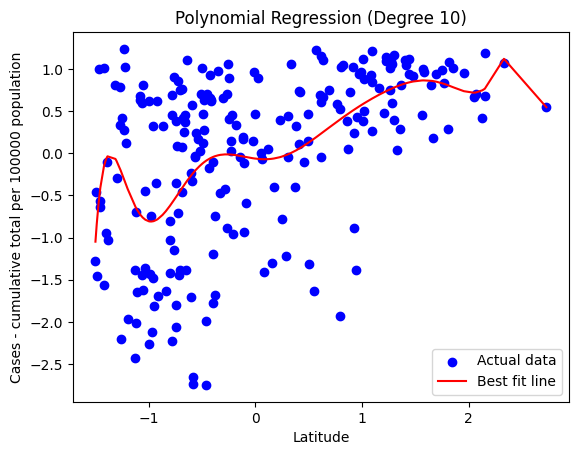

In [189]:
def plot_best_fit_line(model, X, y, poly_features):
    sorted_indices = np.argsort(X.values.flatten())
    X_sorted = X.values[sorted_indices]
    y_sorted = y.values[sorted_indices]
    
    X_poly = poly_features.transform(X_sorted)
    
    y_pred = model.predict(X_poly)
    
    plt.scatter(X, y, color='blue', label='Actual data')
    
    plt.plot(X_sorted, y_pred, color='red', label='Best fit line')
    
    plt.xlabel('Latitude')
    plt.ylabel(target_column)
    plt.title('Polynomial Regression (Degree {})'.format(degree))
    plt.legend()
    
    plt.show()

plot_best_fit_line(polynomial_model, X, y, poly_features)


#### Decision Tree Regression

In [190]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def decision_tree_regression(X, y, max_depth=None):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X, y)
    return model

def evaluate_model(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return r2_scores, mse_scores

merged_data_normalized = merged_data[["Latitude", target_column]].copy()
merged_data_normalized['Latitude'] = abs(merged_data_normalized['Latitude'])
merged_data_normalized[target_column] = np.log(merged_data_normalized[target_column])
scaler = StandardScaler()
merged_data_normalized = pd.DataFrame(scaler.fit_transform(merged_data_normalized), columns=merged_data_normalized.columns)

X = merged_data[['Latitude']]
y = merged_data[target_column]
max_depth = None  
decision_tree_model = decision_tree_regression(X, y, max_depth)


r2_scores_tree, mse_scores_tree = evaluate_model(decision_tree_model, X, y)


print("Mean R2:", np.mean(r2_scores_tree))
print("Mean MSE:", np.mean(mse_scores_tree))



Mean R2: 1.0
Mean MSE: 0.0


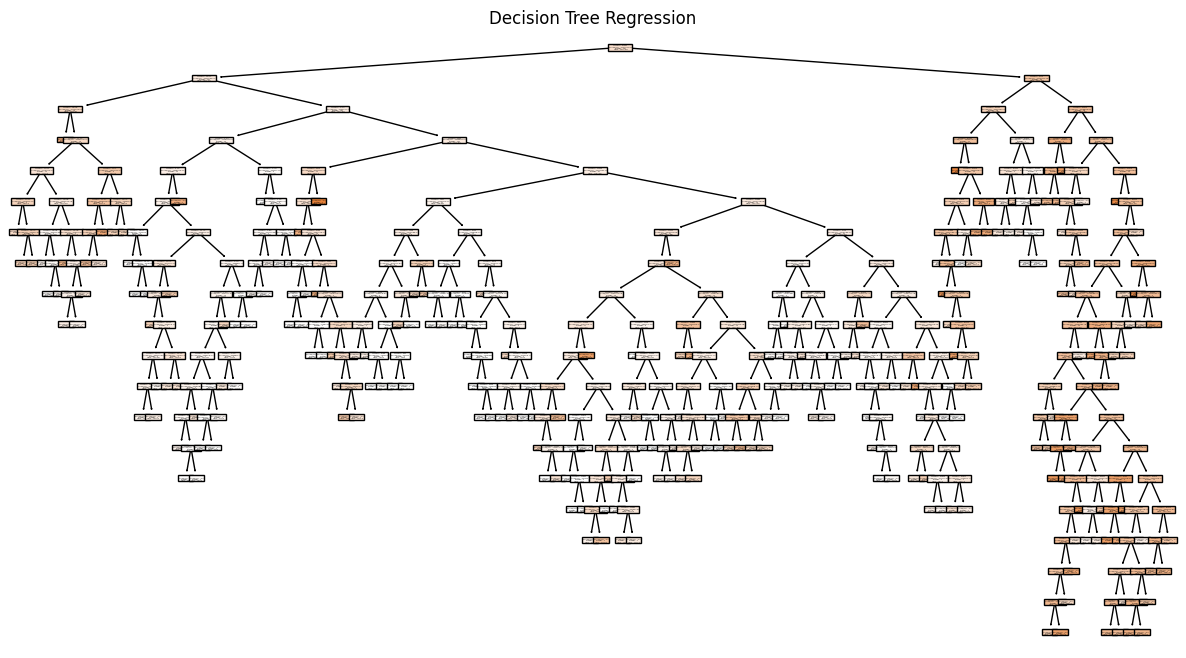

In [191]:

plt.figure(figsize=(15, 8))
plot_tree(decision_tree_model, feature_names=X.columns, filled=True)
plt.title("Decision Tree Regression")
plt.show()

#### SVR

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


def svm_regression(X, y):
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 3, 5, 10],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4],
        'epsilon': [0.1, 0.01, 0.001]
    }

    
    svr = SVR()
    
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
    
    grid_search.fit(X, y)

    print("Best hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

def evaluate_model(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return r2_scores, mse_scores

merged_data_normalized = merged_data[["Latitude", target_column]].copy()
merged_data_normalized['Latitude'] = abs(merged_data_normalized['Latitude'])
merged_data_normalized[target_column] = np.log(merged_data_normalized[target_column])
scaler = RobustScaler()
merged_data_normalized = pd.DataFrame(scaler.fit_transform(merged_data_normalized), columns=merged_data_normalized.columns)


X = merged_data_normalized[['Latitude']]
y = merged_data_normalized[target_column]
svr_model = svm_regression(X, y)

r2_scores_svr, mse_scores_svr = evaluate_model(svr_model, X, y)

print("Mean R2:", np.mean(r2_scores_svr))
print("Mean MSE:", np.mean(mse_scores_svr))



Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean R2: 0.1881760898316751
Mean MSE: 0.400907931173619


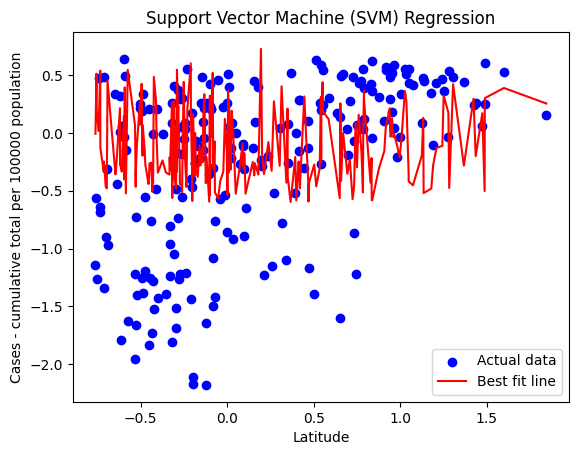

In [193]:

def plot_best_fit_line(model, X, y):
    sorted_indices = np.argsort(X.values.flatten())
    X_sorted = X.values[sorted_indices]
    y_sorted = y.values[sorted_indices]
    
    y_pred = model.predict(X)
    
    plt.scatter(X_sorted, y_sorted, color='blue', label='Actual data')
    
    plt.plot(X_sorted, y_pred, color='red', label='Best fit line')
    
    plt.xlabel('Latitude')
    plt.ylabel(target_column)
    plt.title('Support Vector Machine (SVM) Regression')
    plt.legend()
    
    plt.show()

plot_best_fit_line(svr_model, X, y)


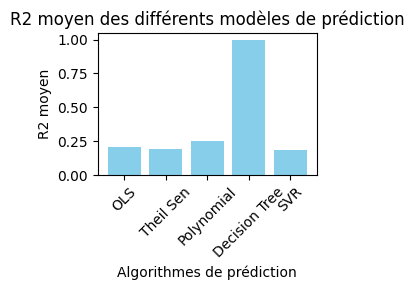

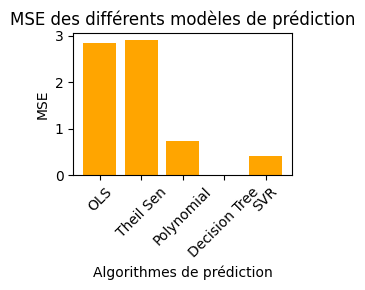

In [194]:
import matplotlib.pyplot as plt

r2_scores = [np.mean(r2_scores_osl), np.mean(r2_scores_ts), np.mean(r2_scores_poly), np.mean(r2_scores_tree), np.mean(r2_scores_svr)]

mse_scores = [np.mean(mse_scores_osl), np.mean(mse_scores_ts), np.mean(mse_scores_poly), np.mean(mse_scores_tree), np.mean(mse_scores_svr)]

algorithms = ['OLS', 'Theil Sen', 'Polynomial', 'Decision Tree', 'SVR']

plt.figure(figsize=(3,3 ))
plt.bar(algorithms, r2_scores, color='skyblue')
plt.xlabel('Algorithmes de prédiction')
plt.ylabel('R2 moyen')
plt.title('R2 moyen des différents modèles de prédiction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(3,3))
plt.bar(algorithms, mse_scores, color='orange')
plt.xlabel('Algorithmes de prédiction')
plt.ylabel('MSE')
plt.title('MSE des différents modèles de prédiction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [195]:
print("Mean R2 Scores:")
for algorithm, r2_score in zip(algorithms, r2_scores):
    print(f"{algorithm}: {r2_score}")

print("\nMean MSE Scores:")
for algorithm, mse_score in zip(algorithms, mse_scores):
    print(f"{algorithm}: {mse_score}")


Mean R2 Scores:
OLS: 0.20854980634363826
Theil Sen: 0.18882098916979775
Polynomial: 0.2491141718129263
Decision Tree: 1.0
SVR: 0.1881760898316751

Mean MSE Scores:
OLS: 2.8346023623056964
Theil Sen: 2.917764173122897
Polynomial: 0.7386924925588438
Decision Tree: 0.0
SVR: 0.400907931173619
